In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [322]:
df_rd = pd.read_csv('roads_transposed.csv')
df_rd.head(5)

road     lrp        lat        lon
0   N1    LRPS  23.706028  90.443333
1   N1   LRPSa  23.702917  90.450417
2   N1   LRPSb  23.702778  90.450472
3   N1  LRP001  23.702139  90.451972
4   N1  LRP002  23.697889  90.460583

In [323]:
n1 = df_rd.groupby('road').get_group('N1')
n1

road      lrp        lat        lon
0      N1     LRPS  23.706028  90.443333
1      N1    LRPSa  23.702917  90.450417
2      N1    LRPSb  23.702778  90.450472
3      N1   LRP001  23.702139  90.451972
4      N1   LRP002  23.697889  90.460583
...   ...      ...        ...        ...
1343   N1  LRP466a  20.868860  92.298222
1344   N1  LRP466b  20.865028  92.298250
1345   N1  LRP466c  20.864667  92.298194
1346   N1   LRP467  20.862972  92.298083
1347   N1     LRPE  20.862917  92.298083

[1348 rows x 4 columns]

In [324]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance # in kilometers

In [325]:
def calc_lrp_distance(df):
    # lrp before
    df_lrp_before = df.shift(1)
    
    # euclidean distance
    #lrp_distance = np.sqrt((df_lrp_before['lat'] - df['lat'])**2 + (df_lrp_before['lon'] - df['lon'])**2)

    # haversine distance
    lrp_distance = df.apply(lambda row: haversine(row['lat'], 
                                                  row['lon'], df_lrp_before.loc[row.name, 'lat'], 
                                                  df_lrp_before.loc[row.name, 'lon']), axis=1)

    return lrp_distance

In [326]:
def get_lrp_offroad(lrp_distance):
    # set threshold
    threshold = lrp_distance.quantile(0.85)
    #print(threshold)

    # both edges before and after the lrp are >>>
    lrp_offroad = lrp_distance.loc[(lrp_distance > threshold) & (lrp_distance.shift(-1) > threshold)]

    return lrp_offroad

In [327]:
def fix_offroad_lrp(df, lrp_offroad):
    # make sure not to overwrite the original df -> result in an annoying warning
    #df_copy = df.copy()
    
    # lat = 1/2 x (lat before + lat after)
    df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_offroad.index])
    # lon = 1/2 x (lon before + lon after)
    df['lon'].loc[lrp_offroad.index] = 0.5 * (df['lon'].shift(1).loc[lrp_offroad.index] + df['lon'].shift(-1).loc[lrp_offroad.index])

    return df

In [328]:
def process_offroad_lrp(df):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(lrp_distance)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

In [329]:
def plot_road(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    #for i, row in df.iterrows():
     #   plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), ha='center')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

In [330]:
def plot_roadname(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    for i, row in df.iterrows():
        plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), 
                     ha='center', fontsize=6, alpha=0.7)
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

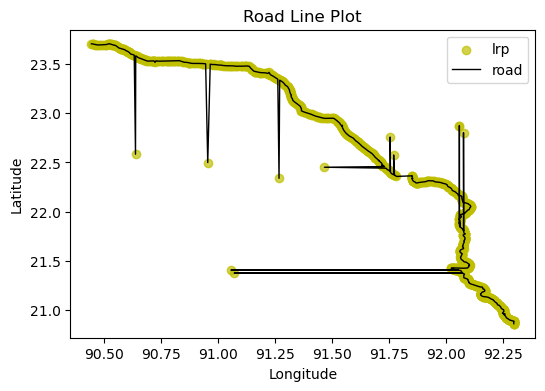

In [331]:
plot_road(n1)

In [332]:
n1_distance = calc_lrp_distance(n1)
n1_distance

0            NaN
1       0.799892
2       0.016446
3       0.168438
4       0.996024
          ...   
1343    0.047136
1344    0.426175
1345    0.040566
1346    0.188773
1347    0.006171
Length: 1348, dtype: float64

In [333]:
n1_distance.describe()

count    1347.000000
mean        1.614110
std        11.224575
min         0.000000
25%         0.096058
50%         0.249108
75%         0.515174
max       112.164894
dtype: float64

In [334]:
# show top 200 distances (in km)
n1_distance.sort_values(ascending=False).head(200).to_list()

[112.16489375714255,
 112.08441437160523,
 112.0087043059964,
 111.84809500232126,
 111.47700336655743,
 111.18257288820872,
 111.10174407943913,
 111.09300290708484,
 110.85863086392966,
 110.69454951156331,
 103.63267655989584,
 103.57033187718115,
 103.54114116394608,
 103.39313940166666,
 39.49608379624209,
 38.918224325595716,
 27.74376124401573,
 27.125807648886163,
 23.038966768680577,
 22.223543285391138,
 7.107518186328391,
 5.622637799532268,
 4.949499908051397,
 2.692918064377957,
 2.240435407390811,
 2.023108308817395,
 1.976484026894498,
 1.8248522247377519,
 1.7239979292354108,
 1.5465009847920486,
 1.3998743694287006,
 1.3874280799601384,
 1.364573013892594,
 1.3043723963688225,
 1.2572227698060774,
 1.2480611370518657,
 1.030188124767654,
 1.0248601084516646,
 1.0182196949423532,
 1.013018308134543,
 1.0052186576930964,
 1.0017244225249482,
 1.0016599132536657,
 1.0008212223406654,
 1.000559779399317,
 0.9998133978173757,
 0.9995792759710141,
 0.9995539775599125,
 0.999

In [335]:
n1_distance.quantile(0.85)

0.7373778727372169

In [336]:
n1_offroad = get_lrp_offroad(n1_distance)
n1_offroad

6         0.855933
9         0.818548
10        0.995578
31        0.927204
69      111.848095
108       1.723998
109       1.824852
115       0.996121
135       0.990864
136       0.958403
141       0.784924
142       0.974675
145       0.999579
148       0.988694
154     111.477003
161       0.999409
169       0.992614
170       0.960265
177       0.959683
180       0.980390
189       0.972766
190       0.993452
199       0.999813
210       0.978440
216       1.399874
233     112.008704
339       1.387428
347       1.030188
348       0.988444
349       0.997056
353       1.024860
354       0.992997
358       0.999554
365       1.001724
366       0.992549
386       1.304372
508       0.909935
529       2.240435
538      27.125808
553      38.918224
567      22.223543
570       1.257223
628       0.791555
680       0.967095
683       0.941925
738       0.901686
787       5.622638
813       0.772534
817     111.182573
818     112.164894
835       0.981686
852       0.989750
869       0.

In [337]:
n1_to_change = n1.loc[n1_offroad.index.to_list()]
n1_to_change

road      lrp        lat        lon
6      N1   LRP003  23.693833  90.469138
9      N1   LRP005  23.694750  90.488500
10     N1   LRP006  23.695916  90.498194
31     N1   LRP014  23.678166  90.555611
69     N1  LRP027a  22.583750  90.636944
108    N1  LRP039a  23.516805  90.722638
109    N1   LRP040  23.532722  90.726999
115    N1   LRP044  23.529999  90.761500
135    N1   LRP054  23.517499  90.851389
136    N1   LRP055  23.517083  90.860778
141    N1   LRP057  23.508806  90.877860
142    N1   LRP058  23.506000  90.886916
145    N1   LRP060  23.506278  90.906389
148    N1   LRP062  23.505528  90.925722
154    N1   LRP065  22.499527  90.954167
161    N1   LRP070  23.491139  90.995027
169    N1   LRP074  23.484639  91.022944
170    N1   LRP075  23.482777  91.032138
177    N1   LRP079  23.480110  91.070638
180    N1   LRP081  23.478194  91.089000
189    N1   LRP086  23.476722  91.136444
190    N1   LRP087  23.468222  91.139444
199    N1   LRP092  23.428888  91.155389
210    N1   LRP097  23.411306  91.198889
216    N1   LRP100  23.415111  91.223249
233    N1   LRP108  22.339055  91.267222
339    N1   LRP150  23.001889  91.392055
347    N1   LRP154  22.977444  91.420583
348    N1   LRP155  22.971138  91.427388
349    N1   LRP156  22.966333  91.435611
353    N1   LRP158  22.956139  91.451778
354    N1   LRP159  22.951444  91.460028
358    N1   LRP162  22.949750  91.488361
365    N1   LRP166  22.932972  91.517222
366    N1   LRP167  22.924888  91.521333
386    N1  LRP174a  22.877777  91.545333
508    N1   LRP216  22.527305  91.701944
529    N1  LRP221a  22.465278  91.720249
538    N1   LRP225  22.451861  91.466611
553    N1  LRP230c  22.758417  91.755139
567    N1  LRP234b  22.576333  91.770527
570    N1  LRP235b  22.358667  91.782277
628    N1   LRP265  22.302500  91.955389
680    N1   LRP283  22.182277  92.051389
683    N1   LRP285  22.165222  92.054889
738    N1   LRP306  22.015306  92.094833
787    N1  LRP321a  21.846444  92.062306
813    N1   LRP331  21.811944  92.077638
817    N1   LRP332  22.802917  92.077277
818    N1   LRP333  21.794194  92.078388
835    N1   LRP339  21.746639  92.080916
852    N1   LRP346  21.686861  92.080083
869    N1   LRP352  21.634833  92.077027
901    N1   LRP364  21.538333  92.063972
918    N1   LRP370  21.490194  92.081805
993    N1  LRP391a  21.407972  91.056000
1016   N1  LRP395b  21.377583  91.070360
1100   N1   LRP415  21.235777  92.151167
1101   N1   LRP416  21.236333  92.158667
1276   N1  LRP454a  20.966028  92.257917

In [338]:
len(n1_offroad)

60

In [339]:
n1_copy = n1.copy()

In [340]:
n1_neo = fix_offroad_lrp(n1_copy, n1_offroad)
n1_neo

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/1303477288.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_o

road      lrp        lat        lon
0      N1     LRPS  23.706028  90.443333
1      N1    LRPSa  23.702917  90.450417
2      N1    LRPSb  23.702778  90.450472
3      N1   LRP001  23.702139  90.451972
4      N1   LRP002  23.697889  90.460583
...   ...      ...        ...        ...
1343   N1  LRP466a  20.868860  92.298222
1344   N1  LRP466b  20.865028  92.298250
1345   N1  LRP466c  20.864667  92.298194
1346   N1   LRP467  20.862972  92.298083
1347   N1     LRPE  20.862917  92.298083

[1348 rows x 4 columns]

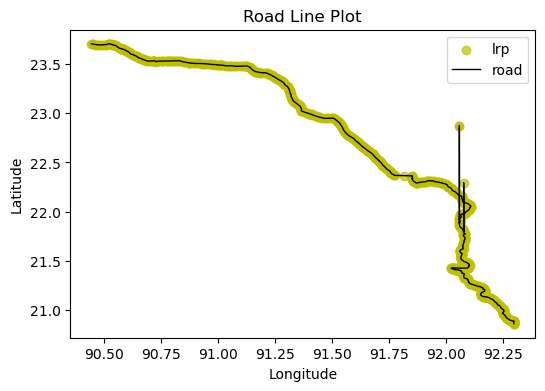

In [341]:
plot_road(n1_neo)

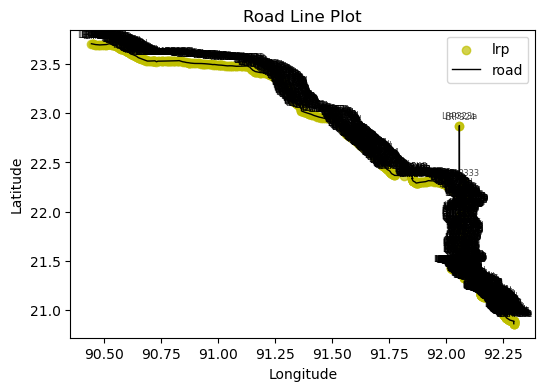

In [342]:
plot_roadname(n1_neo)

unfixed outlier: LRP324 and LRP323a, and LRP333.

So, check are the unfixed lrps even detected as offroad?

In [343]:
lrp_name = ['LRP324','LRP323a','LRP333']
outliers = n1_neo[n1_neo['lrp'].isin(lrp_name)]

outliers

road      lrp        lat        lon
792   N1  LRP323a  22.874916  92.059111
793   N1   LRP324  22.870499  92.059139
818   N1   LRP333  22.295153  92.078083

In [344]:
lrp_index = [789, 790, 791, 792, 793, 794, 795, 796, 816, 817, 818, 819, 820]
rows = n1_neo.iloc[lrp_index]
rows

road      lrp        lat        lon
789   N1   LRP322  21.888389  92.060083
790   N1  LRP322a  21.881027  92.058972
791   N1   LRP323  21.879416  92.059083
792   N1  LRP323a  22.874916  92.059111
793   N1   LRP324  22.870499  92.059139
794   N1  LRP324a  21.862500  92.059500
795   N1   LRP325  21.861639  92.059611
796   N1  LRP325a  21.859722  92.060278
816   N1  LRP331c  21.803028  92.077277
817   N1   LRP332  21.798611  92.077833
818   N1   LRP333  22.295153  92.078083
819   N1  LRP333a  21.787389  92.078888
820   N1  LRP333b  21.786500  92.079027

see index 792 and 793, and 818

In [345]:
n1_neo

road      lrp        lat        lon
0      N1     LRPS  23.706028  90.443333
1      N1    LRPSa  23.702917  90.450417
2      N1    LRPSb  23.702778  90.450472
3      N1   LRP001  23.702139  90.451972
4      N1   LRP002  23.697889  90.460583
...   ...      ...        ...        ...
1343   N1  LRP466a  20.868860  92.298222
1344   N1  LRP466b  20.865028  92.298250
1345   N1  LRP466c  20.864667  92.298194
1346   N1   LRP467  20.862972  92.298083
1347   N1     LRPE  20.862917  92.298083

[1348 rows x 4 columns]

In [346]:
n1_neo1 = n1_neo.copy()

In [347]:
n1_neo_distance = calc_lrp_distance(n1_neo1)

In [348]:
# show top distances (in km)
n1_neo_distance.sort_values(ascending=False).head(30).to_list()

[112.08441437160523,
 110.69454951156331,
 56.460847337794384,
 55.2129239194713,
 3.7851950542841664,
 3.785131557879199,
 1.2480611370518657,
 1.240086340254266,
 1.1945586458839534,
 1.1945222595080627,
 1.048149412618091,
 1.048136368766518,
 1.013018308134543,
 1.009173873187997,
 1.0088458534100115,
 1.005893678882066,
 1.0053847639460676,
 1.0052186576930964,
 1.000559779399317,
 0.9995130572580234,
 0.9993203188906624,
 0.9991793484209822,
 0.9984422167111808,
 0.9984383300619964,
 0.9983337524848185,
 0.9983248016067604,
 0.9964824643778603,
 0.9961222845719735,
 0.9960240984262011,
 0.9956510781425831]

In [349]:
n1_neo_distance.quantile(0.99)

1.0090229840901237

In [350]:
n1_neo_offroad = get_lrp_offroad(n1_neo_distance)
n1_neo_offroad

6        0.895692
9        0.907066
10       0.901985
31       0.919089
109      1.240086
115      0.998442
135      0.925023
136      0.983472
141      0.872843
142      0.820739
145      0.950321
148      0.991763
154      1.048136
161      0.930109
169      0.971081
170      0.923718
177      0.933174
180      0.979274
189      0.892931
190      0.888280
199      0.930922
210      0.998325
216      0.887808
233      0.715681
339      1.194522
347      1.009174
348      1.005385
349      0.870800
353      1.008846
354      1.005894
355      0.991029
358      0.992370
365      0.996482
366      0.999320
508      0.927186
538      0.901220
570      3.785132
628      0.832685
677      1.013018
680      0.877164
683      0.809892
738      0.844066
813      0.766035
818     55.212924
835      0.909989
852      0.980525
869      0.963369
870      0.963372
901      0.954386
918      0.837617
1100     0.805012
dtype: float64

the consecutive 792 and 793 is not detected as offroad LRPs

In [351]:
def get_lrp_offroad2(lrp_distance):
    # set threshold
    threshold = lrp_distance.quantile(0.99)
    #print(threshold)

    # both edges before and after the lrp are >>>
    lrp_offroad = lrp_distance.loc[(lrp_distance > threshold) & (lrp_distance.shift(-1) > threshold)]

    return lrp_offroad

In [352]:
n1_neo_offroad2 = get_lrp_offroad2(n1_neo_distance)
n1_neo_offroad2

154     1.048136
339     1.194522
570     3.785132
818    55.212924
dtype: float64

In [353]:
def fix_consecutive_offroad_lrp(df, offroad_lrp):
    for i in range(0, len(offroad_lrp.index), 2):
        # first offroad lrp
        lrp_start_index = offroad_lrp.index[i]
        # first lrp on road again after a series of offroad lrps
        lrp_end_index = offroad_lrp.index[i + 1]
        # amount of offroad lrps
        total_offroad_lrp = lrp_end_index - lrp_start_index

        # the first and last lrp still on the road
        lrp_before = df.iloc[lrp_start_index - 1]
        lrp_after = df.iloc[lrp_end_index]

        # interpolate the lat and lon values for the offroad lrps
        lat_interval = (lrp_after['lat'] - lrp_before['lat']) / (total_offroad_lrp + 1)
        lon_interval = (lrp_after['lon'] - lrp_before['lon']) / (total_offroad_lrp + 1)

        for j in range(total_offroad_lrp):
            df.loc[lrp_start_index + j, 'lat'] = lrp_before['lat'] + lat_interval * (j + 1)
            df.loc[lrp_start_index + j, 'lon'] = lrp_before['lon'] + lon_interval * (j + 1)
        
    return df

In [354]:
n1_new = fix_offroad_lrp(n1_neo, n1_neo_offroad2)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/1303477288.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_o

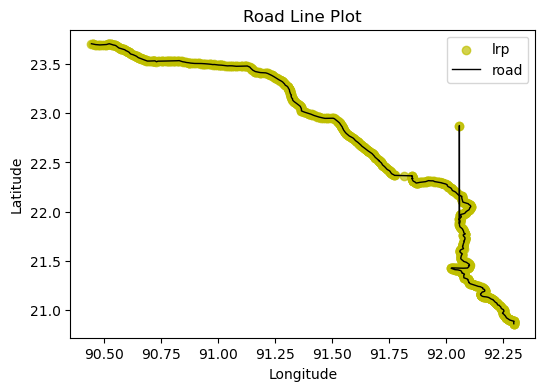

In [355]:
plot_road(n1_new)

In [356]:
n1_new_distance = calc_lrp_distance(n1_new)
n1_new_distance

0            NaN
1       0.799892
2       0.016446
3       0.168438
4       0.996024
          ...   
1343    0.047136
1344    0.426175
1345    0.040566
1346    0.188773
1347    0.006171
Length: 1348, dtype: float64

In [357]:
# show top 10 distances (in km)
n1_new_distance.sort_values(ascending=False).head(10).to_list()

[112.08441437160523,
 110.69454951156331,
 3.7851950542841664,
 3.785131557879199,
 1.2480611370518657,
 1.240086340254266,
 1.1945586458839534,
 1.1945222595080627,
 1.048149412618091,
 1.048136368766518]

In [358]:
def get_consecutive_offroads(df, quantile=0.9, similarity_threshold=0.10, max_group_size=10):
    df['distance'] = calc_lrp_distance(df) # distance to the previous LRP
    threshold = df['distance'].quantile(quantile)

    offroad_lrp_index = df.index[df['distance'] > threshold].tolist()

    # List to store groups of consecutive outliers
    offroad_groups = []
    checked = set()

    for idx in offroad_lrp_index:
        if idx in checked:
            continue

        group = [idx] # assign the index to a new group

        # check the next max_group_size rows for similar lrp_distance values
        for offset in range(1, max_group_size + 1):
            next_idx = idx + offset
            if next_idx in df.index and next_idx not in checked: # get the distance
                ref_distance = df.at[idx, 'distance']
                next_distance = df.at[next_idx, 'distance']

                # check if the next lrp_distance is within similarity threshold
                if abs(ref_distance - next_distance) <= next_distance * similarity_threshold:
                    group.append(next_idx)
                    break
                else:
                    continue

        # only store in groups if there is 2 or more LRP with similar distance
        if 1 < len(group) <= max_group_size:
            offroad_groups.append(group)
            checked.update(group)  # mark indices as checked

    # check if there are any groups before concatenating
    if offroad_groups:
        # consecutive offroads df
        offroad_df = df.loc[np.concatenate(offroad_groups)].copy()
        offroad_df['offroad_group'] = np.repeat(range(1, len(offroad_groups) + 1), [len(g) for g in offroad_groups])
    else:
        offroad_df = pd.DataFrame(columns=df.columns)

    return offroad_df

In [359]:
n1_new_offroad = get_consecutive_offroads(n1_new)

In [360]:
n1_new_offroad

road      lrp        lat        lon  distance  offroad_group
4      N1   LRP002  23.697889  90.460583  0.996024              1
9      N1   LRP005  23.694861  90.489361  0.907066              1
6      N1   LRP003  23.695486  90.470222  0.895692              2
7      N1   LRP004  23.693611  90.478777  0.895704              2
10     N1   LRP006  23.696041  90.498125  0.901985              3
...   ...      ...        ...        ...       ...            ...
918    N1   LRP370  21.491736  92.083486  0.837617             57
1068   N1   LRP407  21.286361  92.100167  0.954500             58
1074   N1   LRP409  21.269583  92.106611  0.989782             58
1259   N1  LRP450a  20.977805  92.250750  0.883380             59
1262   N1  LRP451a  20.969722  92.248555  0.821512             59

[118 rows x 6 columns]

In [361]:
def interpolate_consecutive_offroads(df, offroad_df, max_lrp=5):
    if 'offroad_group' not in offroad_df.columns:
        return df  # No offroad groups to process
        
    for group_id, group in offroad_df.groupby('offroad_group'):
        # last right lrp before outliers
        start_index = group.index[0] - 1
        # first right lrp after outliers
        end_index = group.index[-1] + 1

        # ensure start and end indices are valid
        if start_index < 0 or end_index >= len(df):
            continue 

        start_point = df.loc[start_index, ['lat', 'lon']].values
        end_point = df.loc[end_index, ['lat', 'lon']].values

        # interpolate
        total_lrp = end_index - start_index + max_lrp
        lat_interp = np.linspace(start_point[0], end_point[0], total_lrp)[1:-1]
        lon_interp = np.linspace(start_point[1], end_point[1], total_lrp)[1:-1]

        # assign interpolated values to outlier rows
        for i in range(start_index + 1, end_index):
            df.loc[i, 'lat'] = lat_interp[i - start_index - 1]
            df.loc[i, 'lon'] = lon_interp[i - start_index - 1]
    
    return df

In [362]:
n1_newest = interpolate_consecutive_offroads(n1_new, n1_new_offroad)

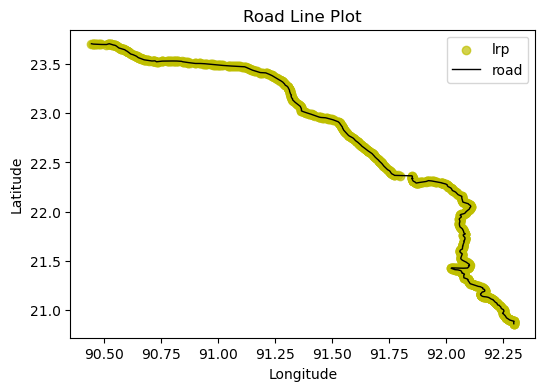

In [363]:
plot_road(n1_newest)

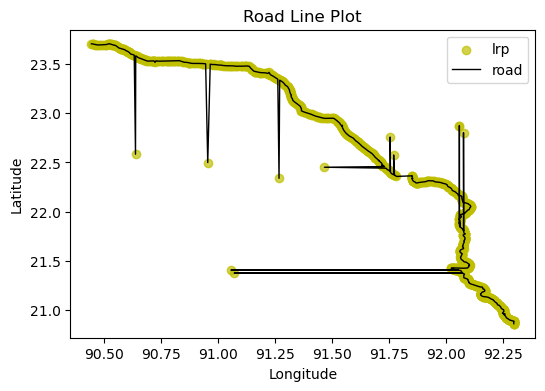

In [364]:
plot_road(n1)

In [365]:
def process_offroad_lrp(df):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad(lrp_distance)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

In [366]:
def process_offroad_lrp2(df):

    lrp_distance = calc_lrp_distance(df)
    lrp_offroad = get_lrp_offroad2(lrp_distance)
    fixed_df = fix_offroad_lrp(df, lrp_offroad)

    return fixed_df

In [367]:
def process_offroad_lrp3(df):

    lrp_offroad = get_consecutive_offroads(df)
    fixed_df = interpolate_consecutive_offroads(df, lrp_offroad)

    return fixed_df

In [368]:
def process_by_road(df, processing_function):
    # Group by 'road' column and apply the process_offroad_lrp function to each group
    processed_groups = df.groupby('road').apply(processing_function)
    
    # Reset the index to combine the groups back together
    processed_df = processed_groups.reset_index(drop=True)
    
    return processed_df

In [369]:
def plot_road_big(df):
    plt.figure(figsize=(16, 12))
    plt.scatter(df['lon'], df['lat'], color='y', alpha=0.7,
                label='lrp')
    plt.plot(df['lon'], df['lat'], color='k', alpha=1, linewidth=1,
            label='road')
        
    # Annotate each point with the 'lrp' label
    #for i, row in df.iterrows():
     #   plt.annotate(row['lrp'], (row['lon'], row['lat']), textcoords="offset points", xytext=(0, 5), ha='center')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Line Plot')
    plt.legend()
    plt

    plt.show()

In [370]:
df_rd.head(5)

road     lrp        lat        lon
0   N1    LRPS  23.706028  90.443333
1   N1   LRPSa  23.702917  90.450417
2   N1   LRPSb  23.702778  90.450472
3   N1  LRP001  23.702139  90.451972
4   N1  LRP002  23.697889  90.460583

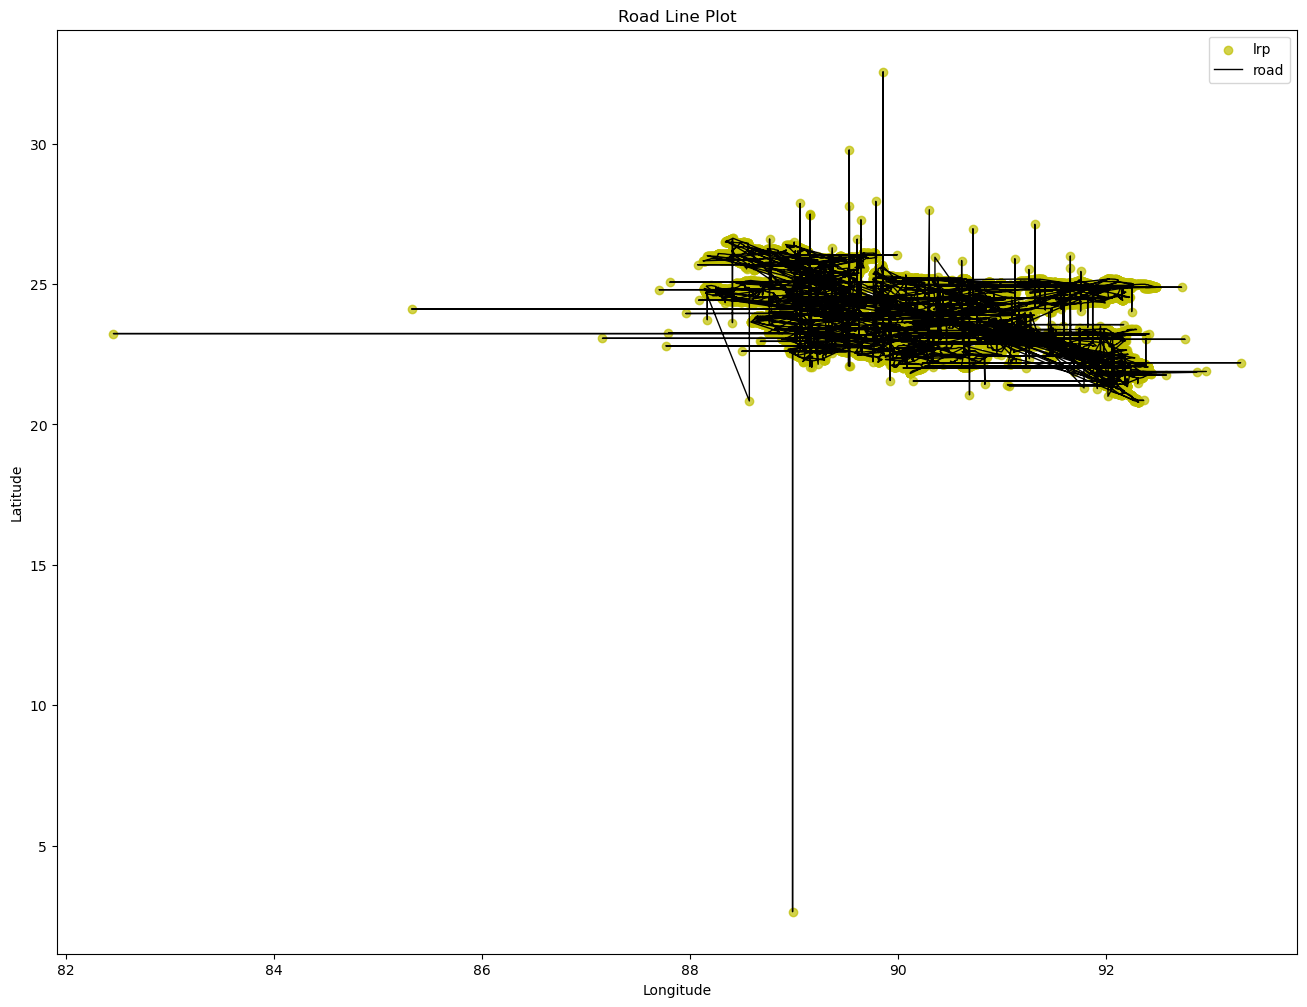

In [371]:
plot_road_big(df_rd)

In [372]:
df_rd1 = process_by_road(df_rd, process_offroad_lrp)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/1303477288.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_o

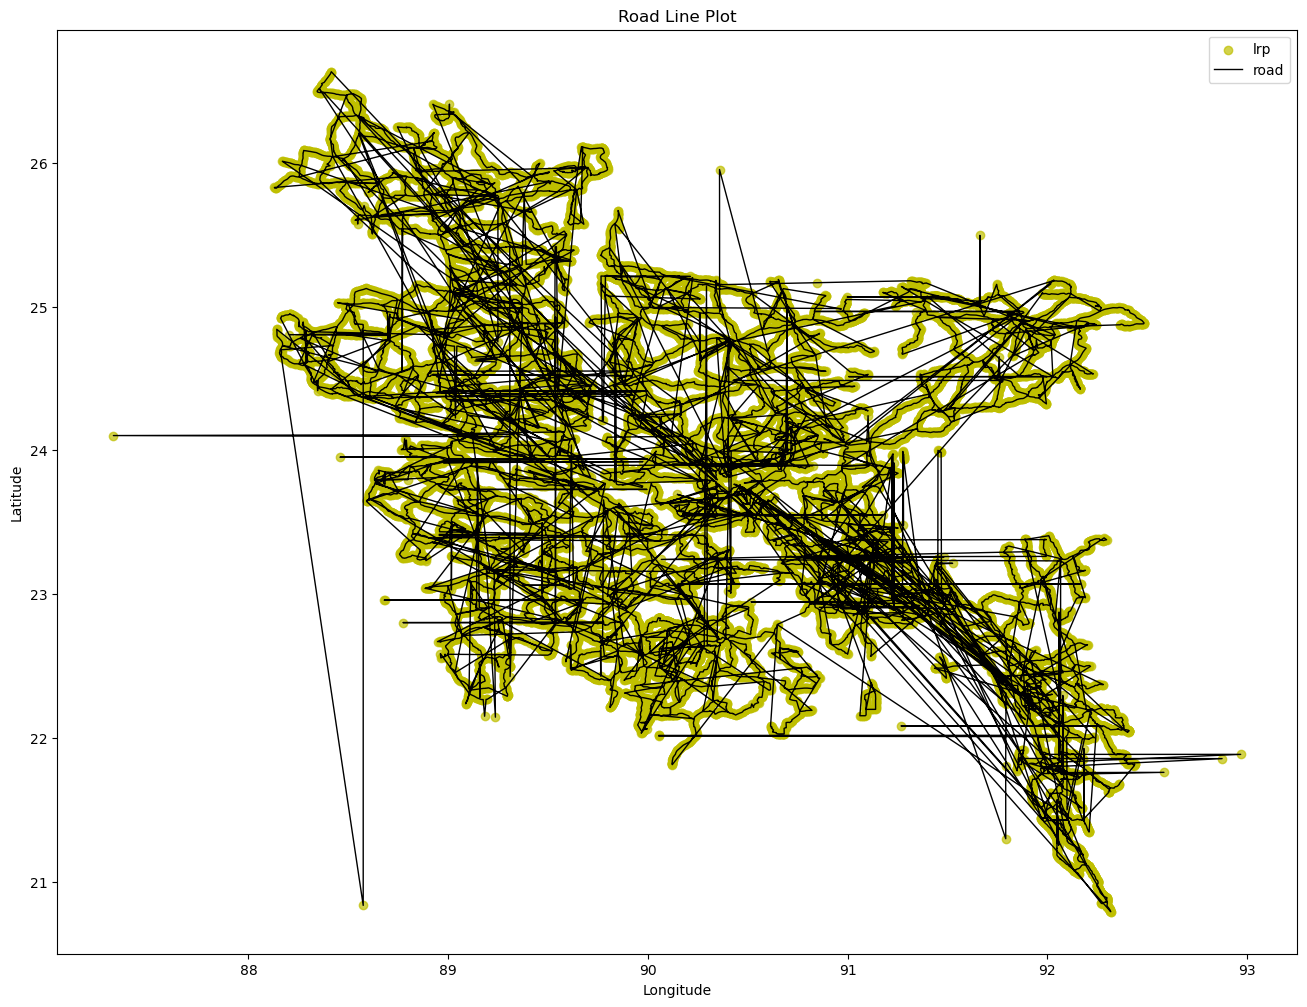

In [373]:
plot_road_big(df_rd1)

In [374]:
df_rd2 = process_by_road(df_rd1, process_offroad_lrp2)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/1303477288.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_o

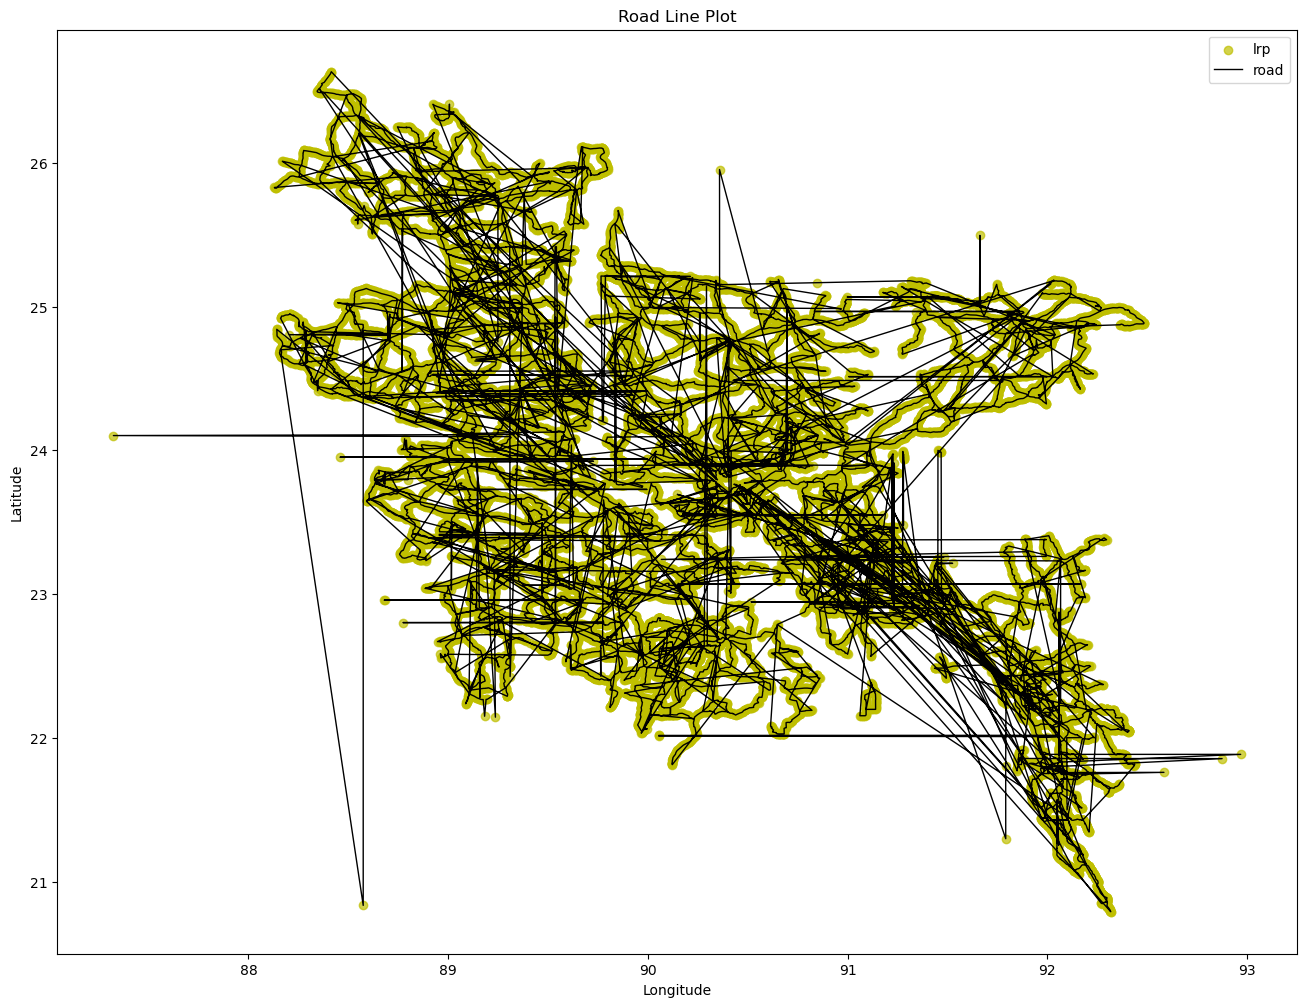

In [375]:
plot_road_big(df_rd2)

In [376]:
df_rd3 = process_by_road(df_rd2, process_offroad_lrp3)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/3532550925.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_groups = df.groupby('road').apply(processing_function)


In [377]:
df_rd4 = process_by_road(df_rd3, process_offroad_lrp)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_877/1303477288.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['lat'].loc[lrp_offroad.index] = 0.5 * (df['lat'].shift(1).loc[lrp_offroad.index] + df['lat'].shift(-1).loc[lrp_o

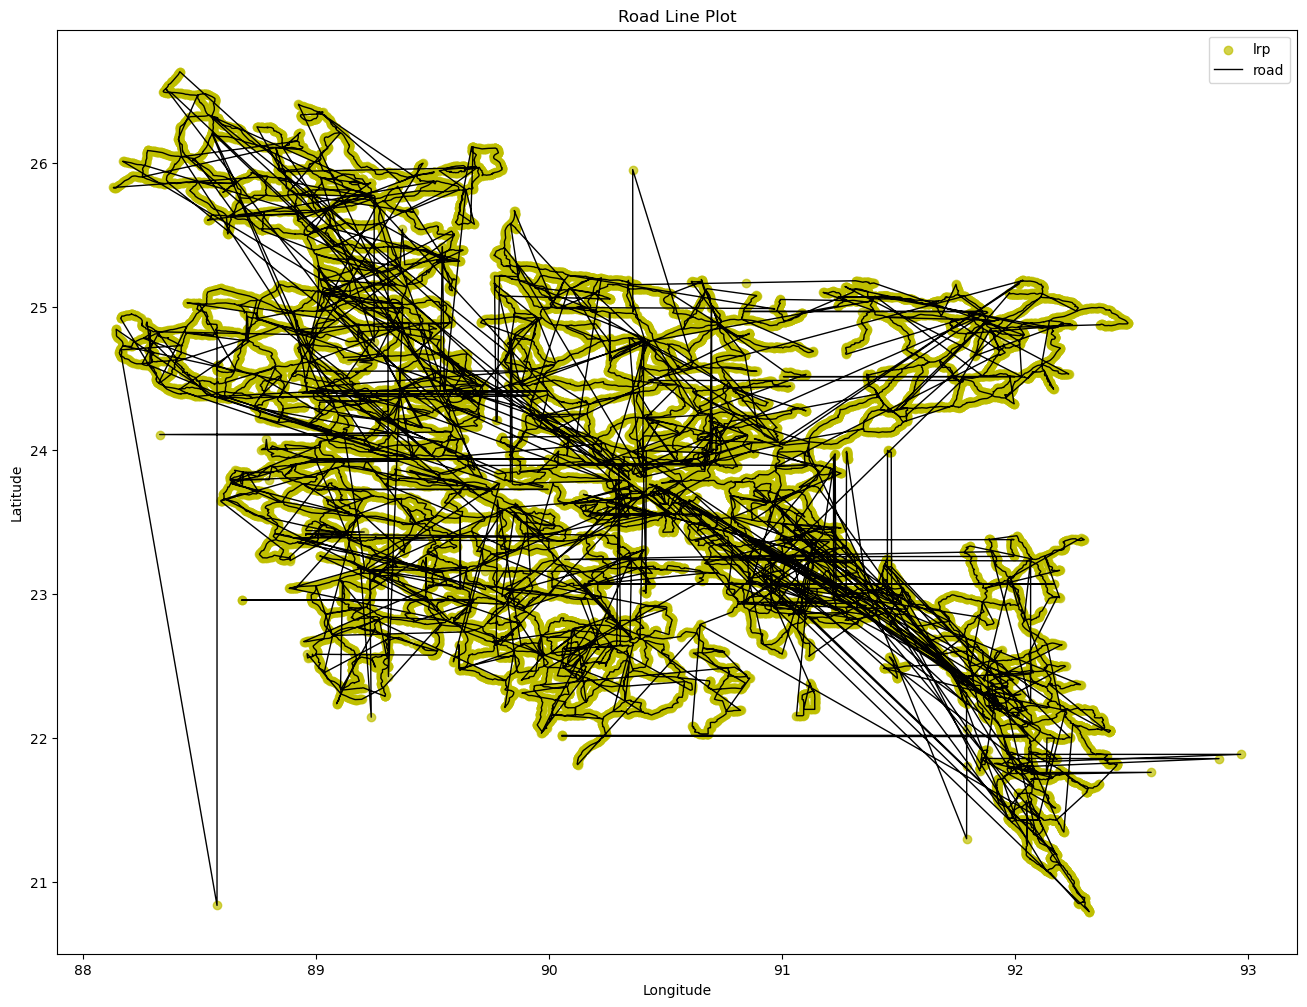

In [378]:
plot_road_big(df_rd4)

In [379]:
# Create a plot function
def plot_map(df_rd):
    plt.figure(figsize=(10, 10))

    for idx, (road, group) in enumerate(df_rd.groupby('road')):
        plt.plot(group['lon'], group['lat'], 'o-', markersize=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

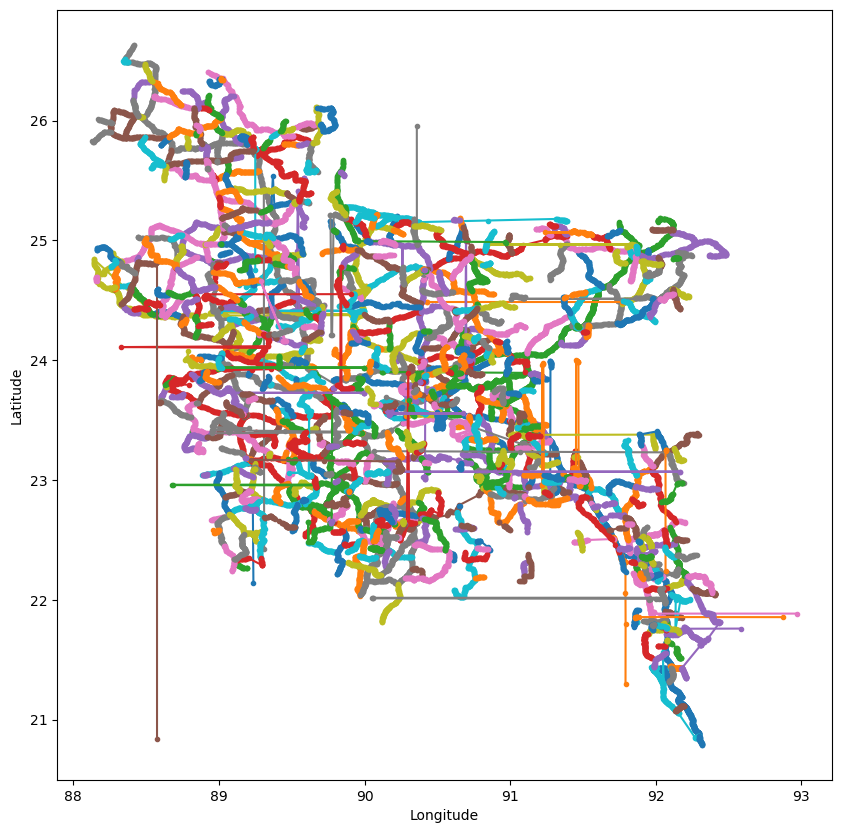

In [380]:
plot_map(df_rd4)

/opt/anaconda3/envs/school/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


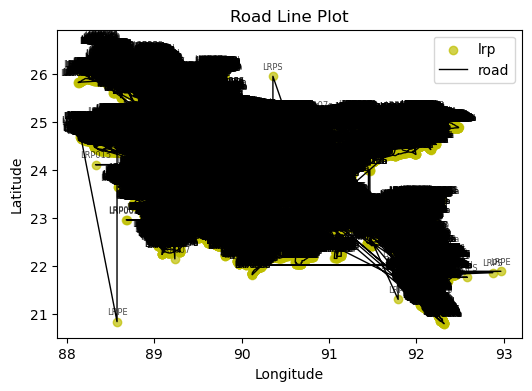

In [381]:
plot_roadname(df_rd4)